In [ ]:
#by Henry Schumacher
#-o-o-o-o-o-o-o-o-o-o-o-o-o-o-o-o-o-o-o-o-o-o-o-o-o-#
import os
import sys
import json
import uuid
import time
import xraydb
import plotly
#-o-o-o-o-o-o-o-o-o-o-o-o-o-o-o-o-o-o-o-o-o-o-o-o-o-#
import numpy as np
import pandas as pd
# import pyxray as xy
import seaborn as sb
import mendeleev as md
import matplotlib as mpl
#-o-o-o-o-o-o-o-o-o-o-o-o-o-o-o-o-o-o-o-o-o-o-o-o-o-#
import matplotlib.pyplot as plt
from scipy.signal import find_peaks
from scipy.optimize import curve_fit
from getmac import get_mac_address as gma
from numba import njit
#-o-o-o-o-o-o-o-o-o-o-o-o-o-o-o-o-o-o-o-o-o-o-o-o-o-#
from matplotlib import rc
# rc('font',**{'family':'sans-serif','sans-serif':['Helvetica']})
## for Palatino and other serif fonts use:
plt.rcParams.update({
    "font.family": "serif",
    "font.serif": ["Times"],
    "text.usetex": True,
    "font.size": 8,
    "pgf.rcfonts": False
})
# rc('font',**{'family':'serif','serif':['Times']})
# rc('text', usetex=True)
# plt.rcParams.update({'font.size': 8})

plt.rcParams.update({
    "pgf.texsystem": "pdflatex",
    "pgf.preamble": "\n".join([
          r"\usepackage{mathtools}",
     ]),
})
#-o-o-o-o-o-o-o-o-o-o-o-o-o-o-o-o-o-o-o-o-o-o-o-o-o-#
def dual_print(output, txt):
    print(txt)
    with open(output, 'a') as out:
        print(txt, file=out)
#-o-o-o-o-o-o-o-o-o-o-o-o-o-o-o-o-o-o-o-o-o-o-o-o-o-#
from colors import load_colors
#-o-o-o-o-o-o-o-o-o-o-o-o-o-o-o-o-o-o-o-o-o-o-o-o-o-#


mac = gma()
print(f"MAC address: {mac}")

mac_dict = {'f4:b5:20:5e:ba:f2': ['C://Users//schum//Documents//Filing Cabinet//1_RootFilesGeant4', 'C://Users//schum//Documents//Filing Cabinet//2_jsonFiles'], # Office
            '14:5a:fc:4f:e8:35': ['D://root_files_temp_storage', 'D://json_files_temp_storage'], # Laptop
            '0x1a7dda7115'  : ['B://IBA//root', 'B://IBA//json']} # Home PC
# Each mac adresse leads to a pair of paths, the first being the folder, 
# where the root files are, the second, where the json files are supposed to be stored
# root_path = mac_dict[mac][0]
json_path = mac_dict[mac][1]

color_schemes = load_colors()
print(color_schemes)

time.strftime("Kernel started: %a, %d %b %Y %H:%M:%S", time.localtime())

MAC address: 14:5a:fc:4f:e8:35
{'c_rainbow': ['#690000', '#C1292E', '#e08e45', '#E0BE36', '#7A8C2A', '#0D863D', '#2d82b7', '#740091'], 'c_complementary': ['#D90368', '#4C5395', '#2CDA9D', '#FA824C', '#3C91E6', '#FFBA08', '#009528', '#6689C6'], 'c_violetorange': ['#5E0ABF', '#701AA4', '#82298A', '#94396F', '#A64854', '#B85839', '#CA671F', '#DC7704'], 'c_five': ['#FFBA08', '#E05A5F', '#3D405B', '#81B29A', '#C45AB3']}


'Kernel started: Wed, 12 Nov 2025 15:37:56'

In [12]:
def combined(a, b, c, d, e):
    """
    Combine three 1D arrays of the same length into an (N, 3) numpy array
    where each row is [a_i, b_i, c_i].
    """
    a, b, c, d, e = (np.asarray(x).ravel() for x in (a, b, c, d, e))
    if not (a.size == b.size == c.size):
        raise ValueError("All inputs must have the same length")
    return np.column_stack((a, b, c, d, e))

In [13]:
size = 10000
rng = np.random.default_rng()
xz = rng.normal(0,1,(2,size))
prime = rng.uniform(-0.1,0.1,(2,size))
momentum = np.ones(size)
initial_vectors = combined(xz[0], prime[0], xz[1], prime[1], momentum)  # shape -> (size, 5)
final_vectors = np.zeros_like(initial_vectors)
print(initial_vectors.shape)
print(initial_vectors[:5])  # show first 5 combined vectors
# r = np.sqrt(xy[0]**2 + xy[1]**2)
# plt.figure(figsize=(4,4), dpi=250)
# plt.scatter(x = xy[0], y = xy[1],s=4,c=r, cmap=mpl.colormaps['plasma'])

(10000, 5)
[[-2.18239654  0.05492952  1.10060998 -0.02954227  1.        ]
 [ 0.27053963  0.03330296  0.05273199 -0.05661458  1.        ]
 [ 1.57600872  0.06834856 -0.53326596 -0.04237452  1.        ]
 [ 0.97372388  0.05383362 -0.52330611  0.05663498  1.        ]
 [ 0.09757531  0.0855981  -0.27457879  0.00595853  1.        ]]


In [ ]:
#s  = 0.1
def matrices(s, l, k):
    '''
    Returns the matrices with the given parameters.\\
    s: effective length of the element [m]\\
    l: length of the element [m]\\
    k: strength of the quadrupole [1/m²]\\
    '''
    Omega = np.sqrt(np.abs(k))*s
    
    matrix_drift = np.array([[1, l, 0, 0, 0],
                            [0, 1, 0, 0, 0],   
                            [0, 0, 1, l, 0],
                            [0, 0, 0, 1, 0],
                            [0, 0, 0, 0, 1]])
    
    matrix_quad_f = np.array([[np.cos(Omega)                    , np.sin(Omega)/np.sqrt(np.abs(k))  , 0                                 , 0                                 , 0],
                            [-np.sqrt(np.abs(k))*np.sin(Omega)  , np.cos(Omega)                     , 0                                 , 0                                 , 0],   
                            [0                                  , 0                                 , np.cosh(Omega)                    , np.sinh(Omega)/np.sqrt(np.abs(k)) , 0],
                            [0                                  , 0                                 , np.sinh(Omega)*np.sqrt(np.abs(k)) , np.cosh(Omega)                    , 0],
                            [0                                  , 0                                 , 0                                 , 0                                 , 1]])
    
    matrix_quad_d = np.array([[np.cosh(Omega)                   , np.sinh(Omega)/np.sqrt(np.abs(k)) , 0                                 , 0                                 , 0],
                            [np.sqrt(np.abs(k))*np.sinh(Omega)  , np.cosh(Omega)                    , 0                                 , 0                                 , 0],   
                            [0                                  , 0                                 , np.cos(Omega)                     , np.sin(Omega)/np.sqrt(np.abs(k))  , 0],
                            [0                                  , 0                                 , -np.sin(Omega)*np.sqrt(np.abs(k)) , np.cos(Omega)                     , 0],
                            [0                                  , 0                                 , 0                                 , 0                                 , 1]])
    
    return matrix_drift, matrix_quad_f, matrix_quad_d



# print(M_d)
# print(M_qf)
# print(M_qd)

[[1.  0.1 0.  0.  0. ]
 [0.  1.  0.  0.  0. ]
 [0.  0.  1.  0.1 0. ]
 [0.  0.  0.  1.  0. ]
 [0.  0.  0.  0.  1. ]]
[[ 0.99500417  0.09983342  0.          0.          0.        ]
 [-0.09983342  0.99500417  0.          0.          0.        ]
 [ 0.          0.          1.00500417  0.10016675  0.        ]
 [ 0.          0.          0.10016675  1.00500417  0.        ]
 [ 0.          0.          0.          0.          1.        ]]
[[ 1.00500417  0.10016675  0.          0.          0.        ]
 [ 0.10016675  1.00500417  0.          0.          0.        ]
 [ 0.          0.          0.99500417  0.09983342  0.        ]
 [ 0.          0.         -0.09983342  0.99500417  0.        ]
 [ 0.          0.          0.          0.          1.        ]]


In [15]:
def k_value(B_pole, r_0, p):
    '''
    B_pole: Magnetic field at pole tip. [T]\\
    r_0: Pole tip radius [m]\\
    p: Particle momentum [GeV/c]
    '''
    c_tilde = 0.2979
    k = B_pole/r_0 * c_tilde/p
    return k

In [16]:
print(k_value(B_pole=0.226, r_0=0.005, p=3))

4.48836


In [1]:
@njit(parallel=True)
def singlematrix_vecstack(matrix, ini_vec):
    num_particles = ini_vec.shape[0]
    print(num_particles)
    for i in range(num_particles):
        final_vectors[i] = np.matvec(matrix, ini_vec[i])
    return final_vectors

@njit(parallel=True)
def singlematrix_vecsingle(matrix, ini_vec):
    final_vectors = np.zeros_like(ini_vec)
    final_vectors = np.matvec(matrix, ini_vec)
    return final_vectors

@njit(parallel=True)
def FODO_vecsingle(ini_vec):
    final_vectors = np.zeros_like(ini_vec)
    #F0D0
    
    final_vectors = np.matvec(M_d,np.matvec(M_qd,np.matvec(M_d,np.matvec(M_qf,ini_vec))))
    return final_vectors

NameError: name 'njit' is not defined

In [34]:
def print_phase_space_diagram(particle_vectors, plane='xx', title='Phase Space Diagram'):
    """
    Plots a phase space diagram for the given vectors.
    
    Parameters:
    vectors : numpy array of shape (N, 5)
        Each row is [x, x', z, z', p]
    plane : str
        'xx' or 'zz' to select the plane to plot
    title : str
        Title of the plot
    """
    if plane == 'xx':
        x = particle_vectors[:, 0]
        prime = particle_vectors[:, 1]
        xlabel = r'$x$ (m)'
        ylabel = r"$x'$ (mrad)"
    elif plane == 'zz':
        x = particle_vectors[:, 2]
        prime = particle_vectors[:, 3]
        xlabel = r'$z$ (m)'
        ylabel = r"$z'$ (mrad)"
    else:
        raise ValueError("plane must be 'x-xprime' or 'y-yprime'")
    
    plt.figure(figsize=(6, 6), dpi=150)
    plt.scatter(x, prime, s=1, alpha=0.5)
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.grid(True)
    plt.xlim(np.min(x)*1.1, np.max(x)*1.1)
    plt.ylim(np.min(prime)*1.1, np.max(prime)*1.1)
    plt.show()

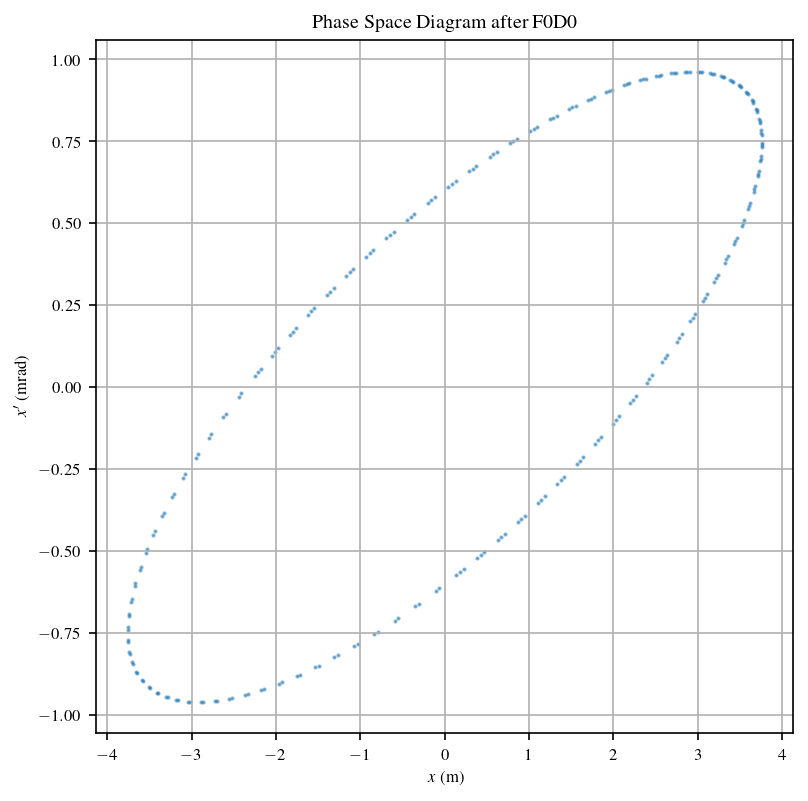

In [35]:
i = 0
iterations = 250
steps_vectors = np.zeros(shape=(iterations,5))
steps_vectors[0] = initial_vectors[0]
M_d, M_qf, M_qd = matrices(s=0.1, l=0.1, k=4)
while i+1 < iterations:
    steps_vectors[i+1] = FODO_vecsingle(steps_vectors[i])
    i += 1
# print(steps_vectors[:5])
print_phase_space_diagram(steps_vectors, plane='xx', title='Phase Space Diagram after F0D0')

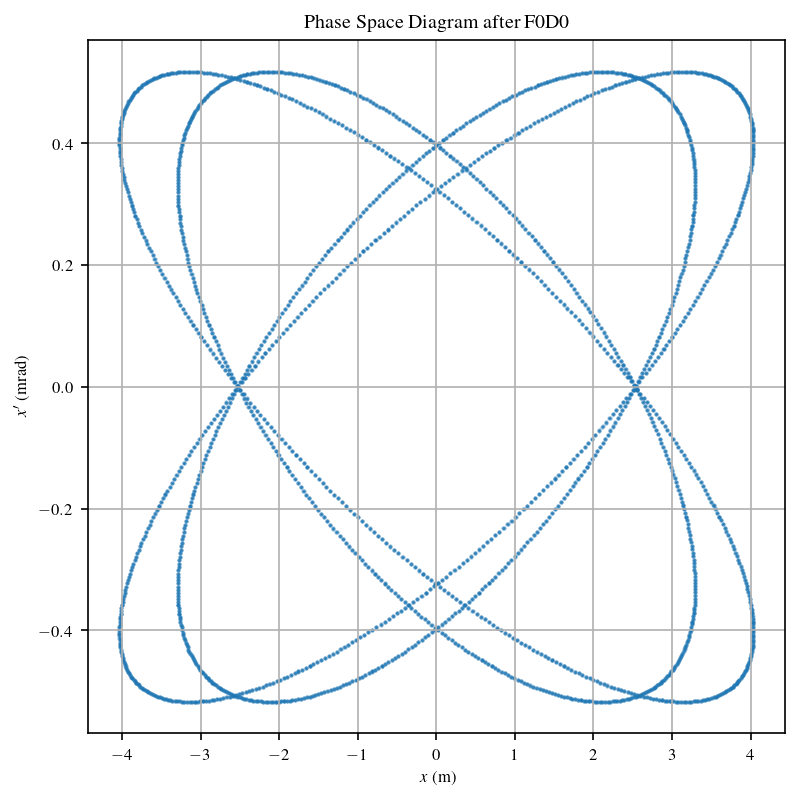

In [36]:
i, j = 0, 0
iterations = 4000
steps_vectors = np.zeros(shape=(iterations,5))
steps_vectors[0] = initial_vectors[0]
M_d, M_qf, M_qd = matrices(s=0.1, l=2, k=2)
while i+1 < iterations:
    if (j%4 == 0):
        steps_vectors[i+1] = singlematrix_vecsingle(M_qf, steps_vectors[i])
    elif (j%4 == 1):
        steps_vectors[i+1] = singlematrix_vecsingle(M_d, steps_vectors[i])
    elif (j%4 == 2):
        steps_vectors[i+1] = singlematrix_vecsingle(M_qd, steps_vectors[i])
    elif (j%4 == 3):
        steps_vectors[i+1] = singlematrix_vecsingle(M_d, steps_vectors[i])
    i += 1
    j += 1
# print(steps_vectors[:5])
print_phase_space_diagram(steps_vectors, plane='xx', title='Phase Space Diagram after F0D0')